# Deep learning for Natural Language Processing


 * Simple text representations, bag of words
 * Word embedding and... not just another word2vec this time
 * rnn for text
 * Aggregating several data sources "the hard way"
 * Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning
 

Special thanks to Irina Golzmann for help with technical part, task prepared by Александр Панин, jheuristic@yandex-team.ru

# NLTK

You will require nltk v3.2 to solve this assignment

__It is really important that the version is 3.2, otherwize russian tokenizer might not work__

Install/update
* `sudo pip install --upgrade nltk==3.2`
* If you don't remember when was the last pip upgrade, `sudo pip install --upgrade pip`

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

# For students with low-RAM machines
 * This assignment can be accomplished with even the low-tier hardware (<= 4Gb RAM) 
 * If that is the case, turn flag "low_RAM_mode" below to True
 * If you have around 8GB memory, it is unlikely that you will feel constrained by memory.
 * In case you are using a PC from last millenia, consider setting very_low_RAM=True

In [1]:
! sudo pip install --upgrade nltk==3.2

The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:318: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/security.html#snimissingwarning.
  SNIMi

In [5]:
low_RAM_mode = True
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [6]:
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
 

In [7]:
print df.shape, df.is_blocked.mean()
df[:5]

(1204949, 13) 0.228222107326


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49
3,10000309,Недвижимость,Квартиры,"1-к квартира, 44 м², 9/20 эт.","В кирпичном пан.-м доме, продается одноком.-ая...","{""Тип объявления"":""Продам"", ""Количество комнат...",2642020,NaN,0,1,0,0,22.47
4,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0.0,1,0,0,0,1.43


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [8]:
print "Blocked ratio",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio 0.228222107326
Count: 1204949


# Balance-out the classes
* Vast majority of data samples are non-prohibited
 * 250k banned out of 4kk
 * Let's just downsample random 250k legal samples to make further steps less computationally demanding
 * If you aim for high Kaggle score, consider a smarter approach to that.


In [9]:
#downsample
import random

num_of_blocked_samples = df.is_blocked.sum()
not_blocked_df = df[df.is_blocked == 0]
not_blocked_indexes = set(not_blocked_df.index) 
downsample_indexes = set()

while len(downsample_indexes) < num_of_blocked_samples:
    index = random.randint(0, len(not_blocked_df) - 1)
    if index not in downsample_indexes:
        downsample_indexes.add(index)
    
df = pd.concat([df[df.is_blocked == 1], not_blocked_df.iloc[list(downsample_indexes)]])

print "Blocked ratio:", df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio: 0.5
Count: 549992


In [10]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print "All tests passed"

All tests passed


In [11]:
#In case your RAM-o-meter is in the red
if very_low_RAM:
    data = data[::2]

# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [12]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1

### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

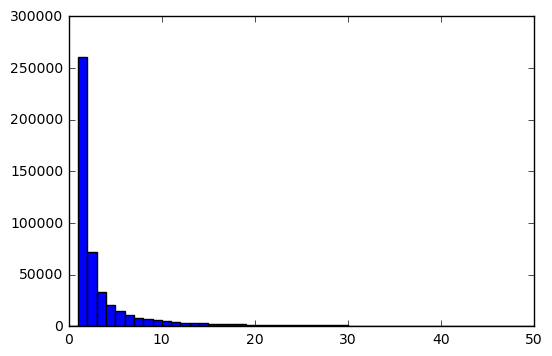

In [13]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [14]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 10
tokens = [pair[0] for pair in [(token, occur) for (token, occur) in token_counts.items() if occur >= min_count]]

In [15]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0

In [16]:
print "# Tokens:",len(token_to_id)
if len(token_to_id) < 30000:
    print "Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc"
if len(token_to_id) < 1000000:
    print "Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc"

# Tokens: 87826
Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc


### Replace words with IDs
Set a maximum length for titles and descriptions.
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [17]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [18]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Data format examples


In [19]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (549992, 15)
Поездки на таможню, печать в паспорте -> [43277 14694 55331 82030 80142 17356     0     0     0     0] ...
Рефлекторно-урогинекологический массаж -> [ 8352     0 30472     0     0     0     0     0     0     0] ...
Возьму суду под200 т. р -> [28848 23438     0  3638 33981     0     0     0     0     0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing.

In [20]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]

In [21]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df[["category","subcategory"]].values
categories = [{"category": sample[0], "subcategory": sample[1]} for sample in data_cat_subcat]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [22]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Split data into training and test

In [23]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [24]:
#Split into training and test set.
from sklearn.cross_validation import train_test_split

#Difficulty selector:
#Easy: split randomly
#Medium: select test set items that have item_ids strictly above that of training set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard

title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = train_test_split(
    title_tokens, desc_tokens, df_non_text, target)
data_tuple = title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [1]:
save_prepared_data = False #save
read_prepared_data = True #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    print "Saving preprocessed data (may take up to 3 minutes)"

    import pickle
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "готово"
    
elif read_prepared_data:
    print "Reading saved data..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print "done"        

Reading saved data...
done


In [2]:
nontext_tr = nontext_tr.values
nontext_ts = nontext_ts.values

# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles: RNN
* Separate input for description: RNN
* Separate input for categorical features: обычные полносвязные слои или какие-нибудь трюки
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal with binary_crossentropy
 * 2 softmax with categorical_crossentropy - essentially the same as previous one
 * 1 neuron without nonlinearity (lambda x: x) +  hinge loss
 

In [3]:
#libraries
import lasagne
from theano import tensor as T
import theano

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5105)


In [4]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

# NN architecture

In [6]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [43]:
# Descriptions

#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.

descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id) + 1, output_size=300)
descr_nn = lasagne.layers.GRULayer(descr_nn, num_units=512)
descr_nn = lasagne.layers.GRULayer(descr_nn, num_units=512)
descr_nn = lasagne.layers.flatten(descr_nn)

# Titles
title_nn = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id) + 1, output_size=64)
title_nn = lasagne.layers.GRULayer(title_nn, num_units=128)
title_nn = lasagne.layers.GRULayer(title_nn, num_units=128)
title_nn = lasagne.layers.flatten(title_nn)

# Non-sequences
cat_nn = lasagne.layers.DenseLayer(cat_inp, num_units=256)
cat_nn = lasagne.layers.DropoutLayer(cat_nn, p=0.5)
cat_nn = lasagne.layers.DenseLayer(cat_inp, num_units=256)

In [44]:
nn = lasagne.layers.ConcatLayer([descr_nn, title_nn, cat_nn])                                

nn = lasagne.layers.DenseLayer(nn, 512)
nn = lasagne.layers.DropoutLayer(nn, p=0.5)
nn = lasagne.layers.DenseLayer(nn, 1, nonlinearity=lasagne.nonlinearities.linear)

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
 * Function description may mention some +-1  limitations - this is not neccessary, at least as long as hinge loss has a __default__ flag `binary = True`

In [45]:
#All trainable params
weights = lasagne.layers.get_all_params(nn, trainable=True)

In [46]:
#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction, target_y, delta=1.0).mean()

In [47]:
#Weight optimization step
updates = lasagne.updates.adam(loss, weights)

### Determinitic prediction 
 * In case we use stochastic elements, e.g. dropout or noize
 * Compile a separate set of functions with deterministic prediction (deterministic = True)
 * Unless you think there's no neet for dropout there ofc. Btw is there?

In [48]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn, deterministic=True)[:,0]

#equivalent loss function
det_loss = lasagne.objectives.binary_hinge_loss(prediction, target_y, delta=1.0).mean()

### Coffee-lation

In [49]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [50]:
#average precision at K

from oracle import APatK, score

In [51]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize", 100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        
        yield [arr[excerpt] for arr in arrays]

### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs

* AUC is the most stable of all three metrics

* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [52]:
from sklearn.metrics import roc_auc_score, accuracy_score
import time

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 100

for i in range(n_epochs):
    #training
    start_time = time.time()
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Epoch number {}".format(i)
    print "Train:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Val:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    print 'Work time {}'.format(time.time() - start_time)
    start_time = time.time()

Epoch number 0
Train:
	loss: 2924.04626502
	acc: 0.70504950495
	auc: 0.735519672844
	ap@k: 0.158319988635
Val:
	loss: 7424.88709957
	acc: 0.747425742574
	auc: 0.782356515874
	ap@k: 0.931569104105
Work time 68.2657101154
Epoch number 1
Train:
	loss: 2740.1963859
	acc: 0.770396039604
	auc: 0.786803092065
	ap@k: 0.0946112565704
Val:
	loss: 2353.30699176
	acc: 0.795346534653
	auc: 0.803518844304
	ap@k: 0.950556243755
Work time 68.1147208214
Epoch number 2
Train:
	loss: 2432.00662736
	acc: 0.786435643564
	auc: 0.80121458171
	ap@k: 0.171131194238
Val:
	loss: 325.505945642
	acc: 0.787425742574
	auc: 0.827257554407
	ap@k: 0.377660943463
Work time 67.8178021908
Epoch number 3
Train:
	loss: 82.5427772679
	acc: 0.776435643564
	auc: 0.852604434865
	ap@k: 0.346601737444
Val:
	loss: 537.103738846
	acc: 0.691881188119
	auc: 0.839502403424
	ap@k: 0.723170153299
Work time 67.7043008804
Epoch number 4
Train:
	loss: 205.866526548
	acc: 0.751287128713
	auc: 0.866880539383
	ap@k: 0.435837314818
Val:
	loss:

In [27]:
print "If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. "

If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. 


# Final evaluation
Evaluate network over the entire test set

In [53]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 0.162176783976
	acc: 0.955625909753
	auc: 0.979378256063
	ap@k: 0.97074891125

AUC:
	Отличное решение! (good)

Accuracy:
	Отличный результат! (good)

Average precision at K:
	Отличный результат (good)


# Main task

* https://goo.gl/forms/eJwIeAbjxzVuo6vn1
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther

* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92

* Remember the training, Luke
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
 * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.